# 주요 프로세스
1. 각 변수에서 로그 변환이 필요한 변수들 변환
> MinMaxScaler를 통해 불균형한 변수들을 찾고 해당 변수들 로그 변환 수행
2. 변수들 스케일링 수행 -> RobustScaler : 중앙값(median)이 0, IQR(interquartile range)이 1이 되도록 변환.
> 아웃라이어의 영향을 최소화한 기법이다. 중앙값(median)과 IQR(interquartile range)을 사용하기 때문에 StandardScaler와 비교해보면 표준화 후 동일한 값을 더 넓게 분포 시키고 있다.
    * 변수들을 스케일링 하지만 감정변수들과 세 해외 지표들을 수행하지 않음 -> 감정변수들은 이미 확률값이고 세 지표들은 변동률을 나타내어 고유의 값을 반영시키고자 함

3. 한국과 관련된 변수들만 남기기
> 너무 변수가 많아서 그런 것인지, 신경망을 학습시켰을 때 정확도와 f1 score가 좋지 않았음

4. 랜덤포레스트 모델의 변수중요도를 통해 상위 변수 50개만 선별

5. 신경망 구축

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,GRU
from keras.optimizers import Adam, RMSprop
from keras.losses import binary_crossentropy


import seaborn as sns

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [4]:
feature =pd.read_csv('final2.csv')

In [84]:
f = pd.read_csv('datasets/KOSPI_국면분석.csv', encoding = 'cp949')

In [5]:
feature

,날짜,지수종가,종가이동평균_5,거래량,거래량이동평균_5,자본금,전체종목수,상승종목수,하락종목수,보합종목수,...,자동차판매[AutoSales][미국],자본금융수지[브라질],자본수지,장단기금리차(%p)(선행),재고순환지표(%p)(선행),재고지수[미국],재정수지[미국],제조업평균가동률지수(계절조정),제조업평균가동률지수(원지수),직접투자[브라질]
0,2001-01-08,586.65,553.580,558645100,19.873264,84853590,902,533,278,45,...,8708.40,5.404533,-10.965500,1.35,-10.8,41.6,76379.0,95.1,86.9,-1568.746882
1,2001-01-09,589.92,567.374,558967700,20.016030,84881174,902,527,282,49,...,8708.40,5.404533,-10.965500,1.35,-10.8,41.6,76379.0,95.1,86.9,-1568.746882
2,2001-01-10,560.81,575.250,642378200,20.137292,84891369,902,137,698,23,...,8708.40,5.404533,-10.965500,1.35,-10.8,41.6,76379.0,95.1,86.9,-1568.746882
3,2001-01-11,561.79,576.004,518788600,20.163623,84906240,902,574,242,43,...,8708.40,5.404533,-10.965500,1.35,-10.8,41.6,76379.0,95.1,86.9,-1568.746882
4,2001-01-12,587.87,577.408,713787700,20.209960,84909240,902,494,298,68,...,8708.40,5.404533,-10.965500,1.35,-10.8,41.6,76379.0,95.1,86.9,-1568.746882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4440,2018-12-21,2061.49,2066.730,311388800,19.819547,107914395,900,381,445,70,...,5188.39,14.856753,-13.080523,0.59,-5.6,52.9,-204903.0,97.7,101.8,-8323.777291
4441,2018-12-24,2055.01,2063.514,285275000,19.737655,107972455,900,285,538,71,...,5188.39,14.856753,-13.080523,0.59,-5.6,52.9,-204903.0,97.7,101.8,-8323.777291
4442,2018-12-26,2028.01,2056.694,321499300,19.678019,108073277,900,128,724,44,...,5188.39,14.856753,-13.080523,0.59,-5.6,52.9,-204903.0,97.7,101.8,-8323.777291
4443,2018-12-27,2028.44,2046.614,398021300,19.666131,108148532,901,521,331,45,...,5188.39,14.856753,-13.080523,0.59,-5.6,52.9,-204903.0,97.7,101.8,-8323.777291


In [16]:
feature.info()
feature = feature[f_n_n]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4445 entries, 0 to 4444
Columns: 132 entries, 날짜 to 직접투자[브라질]
dtypes: float64(119), int64(12), object(1)
memory usage: 4.5+ MB


In [85]:
f = f.loc[4:,:].reset_index()

In [86]:
f['Y']

0       상승
1       상승
2       상승
3       상승
4       상승
        ..
4440    하락
4441    하락
4442    하락
4443    상승
4444    하락
Name: Y, Length: 4445, dtype: object

In [8]:
feature['Y']=pd.Series(f['Y'])

In [26]:
feature.drop(['변동률'], axis=1, inplace=True)

c:\users\dldud\anaconda3\envs\ai_env\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
feature[feature['날짜']=='2017-01-02']

,전기전자,경상수지,NEG,오차및증감,연중최고가종목수,SELIC,도시가계소비지출(실질)(천원)(후행),서비스업,None,건설기성액(실질)(십억원)(동행),...,OECD경기선행지수[한국],ICT설비투자지수(계절조정),전체종목수,금융수지,지수종가,보합종목수,nasdaq,52주신저가종목수,금괴(일간),52주신고가종목수
3958,17.29,3508.917976,0.343645,5.507878,0,13.594146,1049.556098,18.47,0.036788,9404.67561,...,100.744785,110.614634,894,39.402854,2026.16,72,0.0,31,1151.35,62


In [27]:
train = feature.iloc[:3958,:]
test = feature.iloc[3958:,:]

In [28]:
train.head()

,전기전자,경상수지,NEG,오차및증감,연중최고가종목수,SELIC,도시가계소비지출(실질)(천원)(후행),서비스업,None,건설기성액(실질)(십억원)(동행),...,OECD경기선행지수[한국],ICT설비투자지수(계절조정),전체종목수,금융수지,지수종가,보합종목수,nasdaq,52주신저가종목수,금괴(일간),52주신고가종목수
0,7.41,-605.586667,0.360881,8.84,0,15.49,2029.8,11.03,0.000518,6097.6,...,97.6,89.5,902,1.032,586.65,45,-0.49,1,268.3,6
1,7.39,-605.586667,0.478814,8.84,0,15.49,2029.8,11.32,0.016079,6097.6,...,97.6,89.5,902,1.032,589.92,49,1.89,1,267.4,6
2,7.01,-605.586667,0.555556,8.84,0,15.49,2029.8,11.08,0.000000,6097.6,...,97.6,89.5,902,1.032,560.81,23,3.39,2,266.3,7
3,7.01,-605.586667,0.381705,8.84,0,15.49,2029.8,11.29,0.045477,6097.6,...,97.6,89.5,902,1.032,561.79,43,4.61,2,263.9,5
4,7.37,-605.586667,0.369053,8.84,0,15.49,2029.8,11.83,0.000881,6097.6,...,97.6,89.5,902,1.032,587.87,68,-0.53,1,264.3,6


In [29]:
train.describe()

,전기전자,경상수지,NEG,오차및증감,연중최고가종목수,SELIC,도시가계소비지출(실질)(천원)(후행),서비스업,None,건설기성액(실질)(십억원)(동행),...,OECD경기선행지수[한국],ICT설비투자지수(계절조정),전체종목수,금융수지,지수종가,보합종목수,nasdaq,52주신저가종목수,금괴(일간),52주신고가종목수
count,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,...,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000
mean,26.194078,752.801587,0.378153,0.412015,11.176099,13.844191,2258.840662,14.983610,0.041490,7711.102348,...,100.285019,115.961421,893.900202,3.656550,1473.836481,70.682415,0.027390,18.563163,905.691776,23.301415
std,48.670296,1884.218957,0.045471,10.415618,42.593951,4.355880,92.870169,7.379726,0.025812,612.607619,...,1.424311,18.728963,30.144868,19.948619,526.309530,17.323366,1.457428,42.338407,461.375450,24.738263
min,5.870000,-3008.316667,0.000000,-45.800000,0.000000,7.110000,1104.685366,1.590000,0.000000,6097.600000,...,96.300000,78.900000,832.000000,-71.163000,468.760000,2.000000,-9.140000,0.000000,256.000000,0.000000
25%,10.042500,-386.565224,0.364159,-4.487852,0.000000,10.780310,2209.146534,11.100000,0.038813,7269.240726,...,99.584146,99.909293,863.000000,-8.278685,919.077500,60.000000,-0.610000,3.000000,425.300000,7.000000
50%,14.180000,378.317381,0.376487,0.410263,0.000000,13.013691,2286.776769,13.670000,0.042720,7801.215592,...,100.600000,112.800000,896.000000,2.743691,1645.185000,72.000000,0.050000,7.000000,921.100000,16.000000
75%,19.547500,1125.211035,0.390021,4.880793,0.000000,16.938916,2316.187805,18.700000,0.046296,8089.389558,...,101.167311,132.589767,921.000000,15.123940,1957.247500,83.000000,0.710000,17.000000,1272.050000,31.000000
max,323.820000,9404.400000,0.798948,40.400000,964.000000,26.320000,2388.900000,40.890000,1.000000,9392.458537,...,102.900000,161.500000,939.000000,73.864000,2228.960000,122.000000,11.810000,771.000000,1898.300000,232.000000


In [14]:
train.isnull().sum()

날짜                  0
지수종가                0
종가이동평균_5            0
거래량                 0
거래량이동평균_5           0
                   ..
재정수지[미국]            0
제조업평균가동률지수(계절조정)    0
제조업평균가동률지수(원지수)     0
직접투자[브라질]           0
Y                   0
Length: 132, dtype: int64

## Imbalanced 변수를 찾기 위한 스케일링

In [30]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.drop(['날짜'], axis=1))
train_scaled = pd.DataFrame(data = train_scaled, columns = train.drop(['날짜'], axis=1).columns)
train_scaled = pd.concat([train_scaled, train[['날짜']]], axis=1)
train_scaled.describe()

,전기전자,경상수지,NEG,오차및증감,연중최고가종목수,SELIC,도시가계소비지출(실질)(천원)(후행),서비스업,None,건설기성액(실질)(십억원)(동행),...,OECD경기선행지수[한국],ICT설비투자지수(계절조정),전체종목수,금융수지,지수종가,보합종목수,nasdaq,52주신저가종목수,금괴(일간),52주신고가종목수
count,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,...,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000
mean,0.063922,0.303005,0.473313,0.536102,0.011593,0.350557,0.898725,0.340804,0.041490,0.489703,...,0.603791,0.448685,0.578507,0.515901,0.571001,0.572353,0.437584,0.024077,0.395599,0.100437
std,0.153075,0.151797,0.056914,0.120831,0.044185,0.226751,0.072317,0.187779,0.025812,0.185928,...,0.215805,0.226743,0.281728,0.137551,0.299006,0.144361,0.069567,0.054914,0.280933,0.106630
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.013123,0.211215,0.455798,0.479259,0.000000,0.191062,0.860028,0.241985,0.038813,0.355597,...,0.497598,0.254350,0.289720,0.433604,0.255833,0.483333,0.407160,0.003891,0.103087,0.030172
50%,0.026136,0.272836,0.471228,0.536082,0.000000,0.307324,0.920478,0.307379,0.042720,0.517053,...,0.651515,0.410412,0.598131,0.509606,0.668347,0.583333,0.438663,0.009079,0.404981,0.068966
75%,0.043018,0.333007,0.488168,0.587944,0.000000,0.511656,0.943380,0.435369,0.046296,0.604514,...,0.737471,0.649997,0.831776,0.594972,0.845635,0.675000,0.470167,0.022049,0.618675,0.133621
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
t_d = pd.DataFrame(train_scaled.describe())

In [32]:
# 각 변수별 표준편차가 매우 작으면 데이터가 몰려있는 것
t_d.loc[:,t_d.loc['std',] < 0.1]

,NEG,연중최고가종목수,도시가계소비지출(실질)(천원)(후행),None,COMP,shanghai,하한종목수,상한종목수,snp500,POS,연중최저가종목수,기본 금융 금리,거래량,실업률[한국_SA],NEUT,nasdaq,52주신저가종목수
count,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000
mean,0.473313,0.011593,0.898725,0.041490,0.114779,0.473665,0.005843,0.028042,0.404758,0.498345,0.012437,0.008137,0.130196,0.016463,0.148222,0.437584,0.024077
std,0.056914,0.044185,0.072317,0.025812,0.046440,0.086167,0.023583,0.029656,0.050107,0.047755,0.060155,0.072995,0.087033,0.070981,0.045156,0.069567,0.054914
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.455798,0.000000,0.860028,0.038813,0.102314,0.436364,0.000000,0.010638,0.384647,0.483570,0.000000,0.000029,0.076641,0.004557,0.136032,0.407160,0.003891
50%,0.471228,0.000000,0.920478,0.042720,0.118752,0.472727,0.003221,0.021277,0.405378,0.498593,0.000000,0.000045,0.111288,0.009131,0.144713,0.438663,0.009079
75%,0.488168,0.000000,0.943380,0.046296,0.132290,0.513770,0.006441,0.037234,0.426929,0.511839,0.000000,0.000080,0.159771,0.012281,0.153744,0.470167,0.022049
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## imbalanced featrues
- 로그변환 필요
- 거래량, 상한종목수, 하한종목수, 52주신저가 종목수, 기본 금융 금리, 도시가계소비지출(실질)(천원)(후행), 실업률[한국_SA], 무역수지[베트남], 무역수자[태국]
- 드롭 : 연중최고가 종목수, 연중최저가 종목수
> 그러나 모든 피처의 분포를 비슷하게 만들 필요는 없음. 작은 단위의 변화가 큰 차이를 나타내는 것으로 반영될 수 있기 때문이다.

In [33]:
train_copy = train.copy()
log_trans_list = ['거래량', '상한종목수', '하한종목수', '52주신저가종목수', '기본 금융 금리', '도시가계소비지출(실질)(천원)(후행)', '실업률[한국_SA]'] 
for n in log_trans_list:
    train_copy[n] = np.log1p(train[n])

In [34]:
train_copy[log_trans_list].describe()

,거래량,상한종목수,하한종목수,52주신저가종목수,기본 금융 금리,도시가계소비지출(실질)(천원)(후행),실업률[한국_SA]
count,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000
mean,19.798521,2.150392,1.022384,2.205909,2.741331,7.722096,1.530436
std,0.376175,0.796754,0.852165,1.158501,1.071015,0.045221,0.246223
min,18.730582,0.000000,0.000000,0.000000,2.028148,7.008221,1.386294
25%,19.546363,1.609438,0.000000,1.386294,2.419505,7.700814,1.449214
50%,19.771203,2.197225,1.098612,2.079442,2.587045,7.735336,1.508613
75%,20.019441,2.708050,1.609438,2.890372,2.871726,7.748110,1.547563
max,21.590070,5.932245,6.432940,6.648985,11.738562,7.779007,4.110874


In [36]:
drop_list1 = ['연중최고가종목수', '연중최저가종목수']
train_copy.drop(drop_list1,axis=1, inplace=True)

C:\Users\dldud\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dldud\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 52264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dldud\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 48143 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dldud\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 51613 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dldud\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 44048 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dldud\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 50724 missing from c

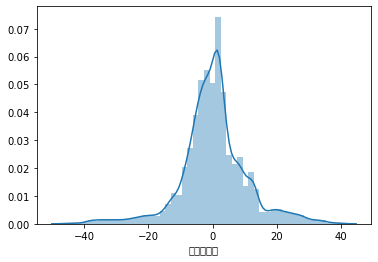

In [72]:
sns.distplot(train['오차및증감'])

In [37]:
#스케일링 
scaler = RobustScaler()
train_scaled = scaler.fit_transform(train_copy.drop(['날짜','COMP', 'NEG', 'NEUT', 'None', 'POS','snp500','nasdaq','shanghai']+log_trans_list, axis=1))
train_scaled = pd.DataFrame(data = train_scaled, columns = train_copy.drop(['날짜','COMP', 'NEG', 'NEUT', 'None', 'POS','snp500','nasdaq','shanghai']+log_trans_list, axis=1).columns)
train_scaled = pd.concat([train_scaled, train_copy[['날짜','COMP', 'NEG', 'NEUT', 'None', 'POS','snp500','nasdaq','shanghai']+log_trans_list]], axis=1)
train_scaled.describe()

,전기전자,경상수지,오차및증감,SELIC,서비스업,건설기성액(실질)(십억원)(동행),건설수주액(실질)(십억원)(선행),상용근로자수(천명)(후행),자본금,원유 WTI,...,snp500,nasdaq,shanghai,거래량,상한종목수,하한종목수,52주신저가종목수,기본 금융 금리,도시가계소비지출(실질)(천원)(후행),실업률[한국_SA]
count,3958.000000,3.958000e+03,3958.000000,3.958000e+03,3958.000000,3958.000000,3.958000e+03,3.958000e+03,3958.000000,3958.000000,...,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000
mean,1.263975,2.477114e-01,0.000187,1.348520e-01,0.172843,-0.109874,1.339719e-01,-7.519612e-01,-0.006078,0.046932,...,0.019917,0.027390,0.017532,19.798521,2.150392,1.022384,2.205909,2.741331,7.722096,1.530436
std,5.120494,1.246361e+00,1.111753,7.072834e-01,0.971017,0.746947,8.413056e-01,2.573407e+00,0.552803,0.566395,...,1.220617,1.457428,1.611318,0.376175,0.796754,0.852165,1.158501,1.071015,0.045221,0.246223
min,-0.874277,-2.240169e+00,-4.932438,-9.586082e-01,-1.589474,-2.077203,-1.554467e+00,-7.645643e+00,-0.863718,-1.083884,...,-9.840000,-9.140000,-8.840000,18.730582,0.000000,0.000000,0.000000,2.028148,7.008221,1.386294
25%,-0.435297,-5.059496e-01,-0.522820,-3.626438e-01,-0.338158,-0.648632,-4.111727e-01,-4.315691e-01,-0.540011,-0.438739,...,-0.470000,-0.610000,-0.680000,19.546363,1.609438,0.000000,1.386294,2.419505,7.700814,1.449214
50%,0.000000,1.881091e-17,0.000000,1.442192e-16,0.000000,0.000000,-1.885021e-16,8.101294e-16,0.000000,0.000000,...,0.035000,0.050000,0.000000,19.771203,2.197225,1.098612,2.079442,2.587045,7.735336,1.508613
75%,0.564703,4.940504e-01,0.477180,6.373562e-01,0.661842,0.351368,5.888273e-01,5.684309e-01,0.459989,0.561261,...,0.560000,0.710000,0.767500,20.019441,2.708050,1.609438,2.890372,2.871726,7.748110,1.547563
max,32.576539,5.970515e+00,4.268466,2.160604e+00,3.581579,1.940188,2.856307e+00,1.243414e+00,1.153170,1.687850,...,14.520000,11.810000,9.860000,21.590070,5.932245,6.432940,6.648985,11.738562,7.779007,4.110874


In [71]:
X_train = train_scaled.drop(['날짜','Y'], axis=1)
y_train = train_scaled['Y']


feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)


rf.fit(X_train, y_train)
importances= rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1] # 처음부터 끝까지 -1칸 간격으로(역순)

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1,30, feat_labels[indices[f]], importances[indices[f]]))

 1) snp500                         0.019991
 2) 지수종가                           0.017381
 3) 종가이동평균_5                       0.016940
 4) 제조업                            0.016619
 5) 코스피 200                        0.015955
 6) nasdaq                         0.015511
 7) 거래량이동평균_5                      0.012519
 8) 전기전자                           0.012023
 9) 서비스업                           0.011942
10) 운수장비                           0.010848
11) 공공행정활동지수                       0.009916
12) USD                            0.009772
13) 거래량                            0.009574
14) 금융수지                           0.009544
15) 52주신저가종목수                      0.009243
16) 실업률[오스트리아_NSA]                 0.009168
17) shanghai                       0.009168
18) 금융계정[브라질]                      0.009052
19) 상승종목수                          0.008969
20) NEUT                           0.008942
21) 자본금                            0.008852
22) 무역수지[아일랜드]                     0.008767
23) POS                         

In [73]:
a=0
for i in importances:
    a += i
print(a)

1.0


In [74]:
sfm = SelectFromModel(rf, threshold = 'median', prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection: 130
Number of features after selection: 65


In [75]:
selected_vars

['지수종가',
 '종가이동평균_5',
 '거래량이동평균_5',
 '자본금',
 '상승종목수',
 '하락종목수',
 '보합종목수',
 '52주신고가종목수',
 '금괴(일간)',
 '원유 WTI',
 'USD',
 '코스피 200',
 '제조업',
 '전기전자',
 '운수장비',
 '서비스업',
 'ISM비제조업지수[미국]',
 '건설업생산지수',
 '경상수지',
 '경상수지[일본]',
 '경상수지[일본](SA)',
 '공공행정활동지수',
 '구인구직비율(%)(선행)',
 '금융계정[브라질]',
 '금융수지',
 '뉴욕제조업지수[미국]',
 '도매매출[일본]',
 '동행지수 순환변동치 전월차(p)',
 '무역수지[룩셈부르크]',
 '무역수지[베트남]',
 '무역수지[아일랜드]',
 '무역수지[태국]',
 '무역수지[포르투갈]',
 '본원소득지급[브라질]',
 '산업생산 증가율[중국]',
 '산업생산[그리스]',
 '산업생산[네덜란드](SA)',
 '산업생산[룩셈부르크]',
 '상품가격지수[미국]',
 '선행지수 순환변동치 전월차(p)',
 '소득수지',
 '수출국(멕시코)',
 '수출국(미국)',
 '수출국(이탈리아)',
 '수출국(칠레)',
 '실업률[스위스_NSA]',
 '실업률[오스트리아_NSA]',
 '실업률[핀란드_NSA]',
 '오차및증감',
 '이전소득수지',
 '자동차판매[AutoSales][미국]',
 '자본금융수지[브라질]',
 '자본수지',
 '재정수지[미국]',
 '직접투자[브라질]',
 'COMP',
 'NEG',
 'NEUT',
 'None',
 'POS',
 'snp500',
 'nasdaq',
 'shanghai',
 '거래량',
 '52주신저가종목수']

# 신경망 구축

In [38]:
feature

,전기전자,경상수지,NEG,오차및증감,연중최고가종목수,SELIC,도시가계소비지출(실질)(천원)(후행),서비스업,None,건설기성액(실질)(십억원)(동행),...,OECD경기선행지수[한국],ICT설비투자지수(계절조정),전체종목수,금융수지,지수종가,보합종목수,nasdaq,52주신저가종목수,금괴(일간),52주신고가종목수
0,7.41,-605.586667,0.360881,8.840,0,15.49,2029.8,11.03,0.000518,6097.6,...,97.60000,89.5,902,1.032000,586.65,45,-0.49,1,268.3,6
1,7.39,-605.586667,0.478814,8.840,0,15.49,2029.8,11.32,0.016079,6097.6,...,97.60000,89.5,902,1.032000,589.92,49,1.89,1,267.4,6
2,7.01,-605.586667,0.555556,8.840,0,15.49,2029.8,11.08,0.000000,6097.6,...,97.60000,89.5,902,1.032000,560.81,23,3.39,2,266.3,7
3,7.01,-605.586667,0.381705,8.840,0,15.49,2029.8,11.29,0.045477,6097.6,...,97.60000,89.5,902,1.032000,561.79,43,4.61,2,263.9,5
4,7.37,-605.586667,0.369053,8.840,0,15.49,2029.8,11.83,0.000881,6097.6,...,97.60000,89.5,902,1.032000,587.87,68,-0.53,1,264.3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4440,5.49,2543.323500,0.358543,-1.091,0,6.40,1.4,25.44,0.037088,8897.7,...,99.18731,104.5,900,37.568336,2061.49,70,-2.99,108,1259.9,36
4441,5.51,2543.323500,0.354360,-1.091,0,6.40,1.4,25.35,0.048192,8897.7,...,99.18731,104.5,900,37.568336,2055.01,71,-2.21,87,1265.5,27
4442,5.45,2543.323500,0.346296,-1.091,0,6.40,1.4,24.78,0.043228,8897.7,...,99.18731,104.5,900,37.568336,2028.01,44,5.84,205,1278.6,44
4443,5.47,2543.323500,0.354153,-1.091,0,6.40,1.4,25.16,0.045312,8897.7,...,99.18731,104.5,901,37.568336,2028.44,45,0.38,40,1275.3,12


In [39]:
feature_m = feature.copy()

In [40]:
for n in log_trans_list:
    feature_m[n] = np.log1p(feature_m[n])

In [42]:
#스케일링 
scaler = RobustScaler()
feam_scaled = scaler.fit_transform(feature_m.drop(['날짜','COMP', 'NEG', 'NEUT', 'None', 'POS','snp500','nasdaq','shanghai']+log_trans_list, axis=1))
feam_scaled = pd.DataFrame(data = feam_scaled, columns = feature_m.drop(['날짜','COMP', 'NEG', 'NEUT', 'None', 'POS','snp500','nasdaq','shanghai']+log_trans_list, axis=1).columns)
feam_scaled = pd.concat([feam_scaled, feature_m[['날짜','COMP', 'NEG', 'NEUT', 'None', 'POS','snp500','nasdaq','shanghai']+log_trans_list]], axis=1)
feam_scaled.describe()

,전기전자,경상수지,오차및증감,연중최고가종목수,SELIC,서비스업,건설기성액(실질)(십억원)(동행),건설수주액(실질)(십억원)(선행),상용근로자수(천명)(후행),자본금,...,snp500,nasdaq,shanghai,거래량,상한종목수,하한종목수,52주신저가종목수,기본 금융 금리,도시가계소비지출(실질)(천원)(후행),실업률[한국_SA]
count,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,...,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000,4445.000000
mean,1.146351,0.271477,-0.001715,9.951631,0.146060,0.188896,0.090744,0.159935,-0.401273,-0.246400,...,0.020333,0.028823,0.011417,19.785980,1.983700,0.914642,2.344902,2.673903,7.009678,1.533867
std,4.959101,1.168311,1.166714,40.343737,0.751915,0.928691,0.928715,0.754510,1.864796,0.562396,...,1.183392,1.416666,1.552455,0.369228,0.911672,0.862977,1.193191,1.031410,2.058285,0.232765
min,-0.911923,-2.133542,-4.664686,0.000000,-0.996388,-1.477427,-1.842618,-1.388199,-5.683130,-1.163211,...,-9.840000,-9.140000,-8.840000,18.730582,0.000000,0.000000,0.000000,1.905088,0.875469,1.386294
25%,-0.456498,-0.511458,-0.515273,0.000000,-0.371435,-0.349887,-0.530192,-0.380479,-0.324437,-0.826708,...,-0.430000,-0.560000,-0.650000,19.537907,1.386294,0.000000,1.609438,2.358057,7.687243,1.458615
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.040000,0.050000,0.000000,19.759115,2.079442,0.693147,2.302585,2.544689,7.730386,1.524350
75%,0.543502,0.488542,0.484727,0.000000,0.628565,0.650113,0.469808,0.619521,0.675563,0.173292,...,0.540000,0.690000,0.710000,20.002562,2.639057,1.386294,3.135494,2.824512,7.746693,1.551513
max,33.284640,5.282308,6.650447,964.000000,2.323361,2.958239,2.648665,2.366682,1.018728,0.792318,...,14.520000,11.810000,9.860000,21.590070,5.932245,6.432940,6.648985,11.738562,7.779007,4.110874


In [76]:
def generator(data, lookback=10, delay=5, min_index=0, max_index=None):
    data = data.values #DataFrame을 넘파이로 바꾸기
    max_index = len(data) - delay -1 #4439
    i = min_index + lookback #index10부터 
    samples = np.zeros((len(range(max_index-i+1)), lookback, data.shape[-1])) #(4430, 10, 65)
    targets = np.zeros((len(range(max_index-i+1)),)) #(4430,)
    while i <= max_index:
        indices = range(i-lookback, i)
        samples[i-lookback] = data[indices]
        if data[i+delay][48] - data[i][48] >= 0:
            targets[i-lookback] = 1
        else:
            targets[i-lookback] = 0
        i += 1
    return samples, targets

In [77]:
samples, targets = generator(feam_scaled.drop(['날짜'], axis= 1), min_index = 0)

In [128]:
feam_scaled['Y'] = feam_scaled['Y'].apply(lambda x: 1 if x=='상승' else 0)

In [79]:
#targets = feam_scaled.loc[1:,'Y']
print(samples.shape)
print(targets.shape) 

(4430, 10, 67)
(4430,)


In [165]:
targets

array([1., 1., 1., ..., 0., 0., 0.])

In [80]:
x_train = samples[:3957]
y_train = targets[:3957]
x_test = samples[3957:]
y_test = targets[3957:]

In [48]:
feature_m.loc[3958,'날짜']

'2017-01-02'

In [49]:
x_train.shape[1]

10

In [62]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [65]:
model = Sequential()
model.add(GRU(32,input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.4))
model.add(GRU(64))
model.add(Dense(32, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')

model.fit(x_train,y_train,batch_size=32,epochs=50,verbose=1,validation_split=0.25, callbacks = [es])

Epoch 1/50
93/93 [==============================] - 6s 63ms/step - loss: 0.6911 - val_loss: 0.6918
Epoch 2/50
93/93 [==============================] - 3s 31ms/step - loss: 0.6825 - val_loss: 0.6987
Epoch 3/50
93/93 [==============================] - 3s 32ms/step - loss: 0.6738 - val_loss: 0.7219
Epoch 4/50
93/93 [==============================] - 3s 32ms/step - loss: 0.6672 - val_loss: 0.6938
Epoch 5/50
93/93 [==============================] - 3s 34ms/step - loss: 0.6604 - val_loss: 0.7071
Epoch 6/50
93/93 [==============================] - 3s 31ms/step - loss: 0.6593 - val_loss: 0.6960
Epoch 7/50
93/93 [==============================] - 3s 32ms/step - loss: 0.6470 - val_loss: 0.7523
Epoch 8/50
93/93 [==============================] - 3s 30ms/step - loss: 0.6391 - val_loss: 0.7423
Epoch 9/50
93/93 [==============================] - 3s 29ms/step - loss: 0.6260 - val_loss: 0.7593
Epoch 10/50
93/93 [==============================] - 3s 29ms/step - loss: 0.6157 - val_loss: 0.7386
Epoch 11/

In [ ]:
# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [137]:
y_test

3958    1
3959    1
3960    1
3961    1
3962    1
       ..
4440    0
4441    0
4442    0
4443    1
4444    0
Name: Y, Length: 487, dtype: int64

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score

In [66]:
scores = model.predict(x_test)
classified_scores=[]
for score in scores:
    if score >= 0.5:
        classified_scores.append(1)
    else:
        classified_scores.append(0)

In [67]:
f1_score(y_test, classified_scores)

0.6222222222222222

In [68]:
accuracy_score(y_test, classified_scores)

0.4608879492600423

# 한국관련 변수만 남기기

In [9]:
f_n = list(feature.columns)

In [10]:
f_n

['날짜',
 '지수종가',
 '종가이동평균_5',
 '거래량',
 '거래량이동평균_5',
 '자본금',
 '전체종목수',
 '상승종목수',
 '하락종목수',
 '보합종목수',
 '상한종목수',
 '하한종목수',
 '연중최고가종목수',
 '연중최저가종목수',
 '52주신고가종목수',
 '52주신저가종목수',
 '변동률',
 '금괴(일간)',
 '국고채권(10년)',
 '원유 WTI',
 'USD',
 '코스피 200',
 '제조업',
 '전기전자',
 '운수장비',
 '서비스업',
 'snp500',
 'nasdaq',
 'shanghai',
 'COMP',
 'NEG',
 'NEUT',
 'None',
 'POS',
 '15세이상인구[구직기간4주]',
 '4주평균신규실업보험청구자수NSA[미국]',
 'Baker Hughes 석유시추회수 월간합계',
 'ICT설비투자지수(계절조정)',
 'ISM비제조업지수[미국]',
 'ISM제조업지수[미국]',
 'NAHB주택시장지수[미국]',
 'OECD 경기선행지수[브라질]',
 'OECD 경기선행지수[중국]',
 'OECD경기선행지수[미국]',
 'OECD경기선행지수[한국]',
 'S&amp;P/Case-Shiller주택가격지수[U.SNational]',
 'SELIC',
 '건설기성액(실질)(십억원)(동행)',
 '건설수주액(실질)(십억원)(선행)',
 '건설수주총액(경상)',
 '건설업생산지수',
 '건설업신뢰지수(EURO17개국)',
 '건축허가건수[미국]',
 '경기동행지수[미국]',
 '경기동행지수전월비(%)[미국]',
 '경기선행지수전월비(%)[미국]',
 '경기체감지수(EURO17개국)',
 '경기후행지수전월비(%)[미국]',
 '경상수지',
 '경상수지[일본]',
 '경상수지[일본](SA)',
 '경제활동참가율[구직기간4주]',
 '고객재고지수[미국]',
 '공공행정활동지수',
 '구인구직비율(%)(선행)',
 '금융계정[브라질]',
 '금융수지',
 '기본 금융 금리',
 '기업재고[미국]',
 '뉴욕제

In [13]:
country = ['미국', '브라질', '중국','EURO17개국','일본','그리스','룩셈부르크','말레이시아','베트남','아일랜드','오스트리아','태국','포르투갈','남아공','네덜란드','스페인','핀란드','인도','멕시코','이탈리아','칠레','스위스']

a=[]
for i in f_n:
    for j in country:
        if j in i:
            a.append(i)
            
f_n_n = set(f_n) - set(a)

In [15]:
len(f_n_n)

69

In [18]:
f_n_n

{'15세이상인구[구직기간4주]',
 '52주신고가종목수',
 '52주신저가종목수',
 'Baker Hughes 석유시추회수 월간합계',
 'COMP',
 'ICT설비투자지수(계절조정)',
 'NEG',
 'NEUT',
 'None',
 'OECD경기선행지수[한국]',
 'POS',
 'S&amp;P/Case-Shiller주택가격지수[U.SNational]',
 'SELIC',
 'USD',
 'nasdaq',
 'shanghai',
 'snp500',
 '거래량',
 '거래량이동평균_5',
 '건설기성액(실질)(십억원)(동행)',
 '건설수주액(실질)(십억원)(선행)',
 '건설수주총액(경상)',
 '건설업생산지수',
 '경상수지',
 '경제활동참가율[구직기간4주]',
 '공공행정활동지수',
 '구인구직비율(%)(선행)',
 '국고채권(10년)',
 '금괴(일간)',
 '금융수지',
 '기본 금융 금리',
 '날짜',
 '도시가계소비지출(실질)(천원)(후행)',
 '동행지수 순환변동치',
 '동행지수 순환변동치 전월차(p)',
 '무역수지',
 '변동률',
 '보합종목수',
 '상승종목수',
 '상용근로자수(천명)(후행)',
 '상한종목수',
 '서비스수지',
 '서비스업',
 '선행지수 순환변동치 전월차(p)',
 '소득수지',
 '소비자기대지수(선행)',
 '실업률[한국]',
 '실업률[한국_SA]',
 '연중최고가종목수',
 '연중최저가종목수',
 '오차및증감',
 '운수장비',
 '원유 WTI',
 '월별 소비자물가등락률(전년비)',
 '이전소득수지',
 '자본금',
 '자본수지',
 '장단기금리차(%p)(선행)',
 '재고순환지표(%p)(선행)',
 '전기전자',
 '전체종목수',
 '제조업',
 '제조업평균가동률지수(계절조정)',
 '제조업평균가동률지수(원지수)',
 '종가이동평균_5',
 '지수종가',
 '코스피 200',
 '하락종목수',
 '하한종목수'}

In [89]:
f['Y'] = f['Y'].apply(lambda x: 0 if x=='하락' else 1)

In [93]:
y_train = f['Y'].iloc[:3958]
y_test = f['Y'].iloc[3958:]

In [94]:
y_train

0       1
1       1
2       1
3       1
4       1
       ..
3953    0
3954    1
3955    1
3956    1
3957    1
Name: Y, Length: 3958, dtype: int64

In [96]:
X_train = feam_scaled.drop(['날짜','오차및증감'], axis=1).iloc[:3958,:]
X_test = feam_scaled.iloc[3958:,:]

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)


rf.fit(X_train, y_train)
importances= rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1] # 처음부터 끝까지 -1칸 간격으로(역순)

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1,30, feat_labels[indices[f]], importances[indices[f]]))

 1) 지수종가                           0.026637
 2) snp500                         0.026230
 3) 제조업                            0.024666
 4) 코스피 200                        0.023669
 5) 종가이동평균_5                       0.022046
 6) nasdaq                         0.021669
 7) 공공행정활동지수                       0.021318
 8) 금융수지                           0.020751
 9) 서비스업                           0.020366
10) 자본금                            0.018778
11) 거래량이동평균_5                      0.018572
12) 전기전자                           0.017586
13) ICT설비투자지수(계절조정)                0.017569
14) 자본수지                           0.017274
15) 운수장비                           0.017154
16) 서비스수지                          0.016800
17) OECD경기선행지수[한국]                 0.016689
18) 경상수지                           0.016629
19) 건설업생산지수                        0.016429
20) 소득수지                           0.016231
21) 제조업평균가동률지수(원지수)                0.016139
22) 구인구직비율(%)(선행)                  0.015916
23) 거래량                         

In [109]:
sfm = SelectFromModel(rf, threshold = '0.86*mean', prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection: 66
Number of features after selection: 51


In [110]:
feam_scaled2 = feam_scaled[selected_vars]


In [144]:
selected_vars

['전기전자',
 '경상수지',
 '서비스업',
 '건설기성액(실질)(십억원)(동행)',
 '건설수주액(실질)(십억원)(선행)',
 '자본금',
 '원유 WTI',
 '하락종목수',
 '제조업',
 '재고순환지표(%p)(선행)',
 '제조업평균가동률지수(원지수)',
 '자본수지',
 '서비스수지',
 'Baker Hughes 석유시추회수 월간합계',
 '실업률[한국]',
 '거래량이동평균_5',
 '이전소득수지',
 '종가이동평균_5',
 '무역수지',
 '상승종목수',
 '건설업생산지수',
 '제조업평균가동률지수(계절조정)',
 '구인구직비율(%)(선행)',
 '건설수주총액(경상)',
 '장단기금리차(%p)(선행)',
 'USD',
 '공공행정활동지수',
 '운수장비',
 '동행지수 순환변동치 전월차(p)',
 '월별 소비자물가등락률(전년비)',
 '경제활동참가율[구직기간4주]',
 '소득수지',
 '선행지수 순환변동치 전월차(p)',
 '동행지수 순환변동치',
 '코스피 200',
 'OECD경기선행지수[한국]',
 'ICT설비투자지수(계절조정)',
 '금융수지',
 '지수종가',
 '금괴(일간)',
 'COMP',
 'NEG',
 'NEUT',
 'POS',
 'snp500',
 'nasdaq',
 'shanghai',
 '거래량',
 '기본 금융 금리',
 '도시가계소비지출(실질)(천원)(후행)',
 '실업률[한국_SA]']

In [118]:
feam_scaled2.iloc[:, 38]

0      -1.203946
1      -1.200610
2      -1.230309
3      -1.229310
4      -1.202702
          ...   
4440    0.300747
4441    0.294136
4442    0.266589
4443    0.267028
4444    0.279883
Name: 지수종가, Length: 4445, dtype: float64

In [117]:
list(feam_scaled2).index('지수종가')

38

In [120]:
def generator(data, lookback=10, delay=5, min_index=0, max_index=None):
    data = data.values #DataFrame을 넘파이로 바꾸기
    max_index = len(data) - delay -1 #4439
    i = min_index + lookback #index10부터 
    samples = np.zeros((len(range(max_index-i+1)), lookback, data.shape[-1])) #(4430, 10, 33)
    targets = np.zeros((len(range(max_index-i+1)),)) #(4430,)
    while i <= max_index:
        indices = range(i-lookback, i)
        samples[i-lookback] = data[indices]
        if data[i+delay][38] - data[i][38] >= 0:
            targets[i-lookback] = 1
        else:
            targets[i-lookback] = 0
        i+=1
    return samples, targets

In [121]:
samples, targets = generator(feam_scaled2, min_index=0, max_index=3500)

In [123]:
def split_data(sample, target, train_size_percentage=80, shuffle=True):
    if shuffle is True:
        index = np.arange(sample.shape[0])
        np.random.shuffle(index)
        sample = sample[index]
        target = target[index]
    train_size = train_size_percentage*sample.shape[0]//100
    test_size = sample.shape[0] - train_size
    
    x_train = sample[:train_size]
    y_train = target[:train_size]
    x_test = sample[train_size:]
    y_test = target[train_size:]
    
    return x_train, y_train, x_test, y_test   

In [124]:
x_train, y_train, x_test, y_test = split_data(samples, targets)

In [137]:
# 얼리스탑핑
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [138]:
model = Sequential()
model.add(GRU(32,input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(64))
model.add(Dense(32, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')

model.fit(x_train,y_train,batch_size=64,epochs=100, verbose=1,validation_split=0.25, callbacks = [es])

Epoch 1/100
42/42 [==============================] - 4s 97ms/step - loss: 0.6895 - val_loss: 0.6792
Epoch 2/100
42/42 [==============================] - 1s 34ms/step - loss: 0.6806 - val_loss: 0.6755
Epoch 3/100
42/42 [==============================] - 2s 39ms/step - loss: 0.6764 - val_loss: 0.6644
Epoch 4/100
42/42 [==============================] - 2s 36ms/step - loss: 0.6697 - val_loss: 0.6685
Epoch 5/100
42/42 [==============================] - 2s 36ms/step - loss: 0.6665 - val_loss: 0.6850
Epoch 6/100
42/42 [==============================] - 2s 36ms/step - loss: 0.6593 - val_loss: 0.6693
Epoch 7/100
42/42 [==============================] - 2s 36ms/step - loss: 0.6549 - val_loss: 0.6685
Epoch 8/100
42/42 [==============================] - 2s 37ms/step - loss: 0.6496 - val_loss: 0.6803
Epoch 9/100
42/42 [==============================] - 2s 40ms/step - loss: 0.6489 - val_loss: 0.6627
Epoch 10/100
42/42 [==============================] - 2s 45ms/step - loss: 0.6424 - val_loss: 0.6540

In [130]:
def eval_acc(models, x_test_data, y_test_data, threshold=0.5):
    scores = models.predict(x_test_data)
    classified_scores=[]
    for score in scores:
        if score >= threshold:
            classified_scores.append(1)
        else:
            classified_scores.append(0)
    
    acc=0
    for i, classified_score in enumerate(classified_scores):
        if classified_score== y_test_data[i]:
            acc+=1
    accuracy_score = acc/len(y_test_data)*100
    
    return str(accuracy_score) + ' %'

In [139]:
eval_acc(model, x_test, y_test)

'75.5079006772009 %'

In [140]:
scores = model.predict(x_test)
classified_scores=[]
for score in scores:
    if score >= 0.5:
        classified_scores.append(1)
    else:
        classified_scores.append(0)

In [141]:
from sklearn.metrics import f1_score, accuracy_score
accuracy_score(y_test, classified_scores)


0.755079006772009

In [142]:
f1_score(y_test, classified_scores)

0.7874632713026446

# 모의 투자

In [145]:
df = pd.DataFrame()
data_df = pd.read_csv('final2.csv')
df['x'] = data_df['지수종가'][-886:]
df['y']=classified_scores

In [146]:
money = 100000000
stock = 0
aa=[]
for j in range(5):
    money = 100000000
    stock = 0
    for i in range(j,886,5):
        a = []
        x=df['x'].iloc[i]
        y=df['y'].iloc[i]
        if y == 1 and money>0:
            stock = money/x
            money = 0
        if y == 0 and money==0:
            money = stock*x
            stock = 0
        a.append(money)
        a.append(stock)
    if a[0]==0:
        print(a[1]*x)
        aa.append(a[1]*x)
    else:
        print(a[0])
        aa.append(a[0])

100583459.00437605
104309680.1788293
105454921.70738369
106060084.34327151
101506727.2053084


In [147]:
print(sum(aa)/5000000)

103.58297448783378


# 모의 투자 결과 v2
![title](모의투자결과2.png) 

